In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.crs import CRS
from rasterio.warp import transform_bounds
import scipy.ndimage as nd
from shapely.geometry import Polygon, shape, LinearRing, LineString, MultiPolygon
from orinoco import (filter_binary_array_by_min_size,
                     reproject_arr_to_new_crs,
                     reproject_profile_to_new_crs,
                     reproject_arr_to_match_profile,
                     convert_4326_to_utm,
                     scale_img,
                     rasterize_shapes_to_array,
                     polygonize_array_to_shapefile)

# Loading the Tiff

*Warning*: `google_16` is a large one!

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
product_dir.mkdir(exist_ok=True)

In [4]:
products_for_map_dir = product_dir/map_name
products_for_map_dir.mkdir(exist_ok=True)

In [5]:
with rasterio.open(data_path/f'{map_name}.tif') as ds:
    src_arr = ds.read()
    bounds = ds.bounds
    src_profile = ds.profile
    src_crs = dict(ds.crs)

In [6]:
src_profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1335, 'height': 1033, 'count': 4, 'crs': CRS.from_epsg(3857), 'transform': Affine(38.21552256970537, 0.0, -10190675.992975753,
       0.0, -38.23273802623928, 3462892.8103504805), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

We have to convert this to BSQ (band sequential) for numpy and select first 3 bands.

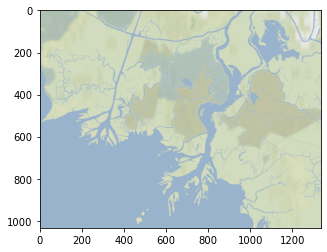

In [7]:
plt.imshow(src_arr.transpose([1, 2, 0])[..., :3])

# Extract Water

We used QGIS to determine approximate color of water and some of the text labels, if any.

In [8]:
def obtain_mask_from_color(arr, rgb_fixed, tol=3):
    """
    Looking at the first 3 channels of our image, we look at +/- 
    tolerance within some fixed 3 channel value (given by rgb_fixed)
    """
    X = arr.astype(float)
    mask_r = (np.abs(X[..., 0] - rgb_fixed[0]) < tol)
    mask_g = np.abs(X[..., 1] - rgb_fixed[1]) < tol
    mask_b = np.abs(X[..., 2] - rgb_fixed[2]) < tol
    return mask_r & mask_g & mask_b

These masks values are done by hand. There is nothing pretty or elegant about this, but it's certainly "prettier" than making your own water mask with satellite data.

In [9]:
X = src_arr.transpose([1, 2, 0])[..., :3]


if map_name == 'stamen_terrain_12':
    mask_original_crs = obtain_mask_from_color(X, [153, 179, 204])
elif map_name == 'google_16':
    #We not only need water but the various text values 
    # littered around the map. This is denoted by `mask_text_<i>`.
    mask_water = obtain_mask_from_color(X, [170, 218, 255])
    
    mask_text_0 = obtain_mask_from_color(X, [122, 158, 174])
    mask_text_1 = obtain_mask_from_color(X, [126, 146, 158])
    mask_text_2 = obtain_mask_from_color(X, [99, 150, 213])
    mask_text_3 = obtain_mask_from_color(X, [75, 130, 198])

    mask_text = mask_text_0 | mask_text_1 | mask_text_2 | mask_text_3

    # To make sure the text gets removed we are going to create a 2 pixel buffer.
    mask_text = nd.morphology.binary_dilation(mask_text, 
                                              iterations=2,
                                              border_value=0,
                                              structure=np.ones((3, 3)))


    mask_original_crs = mask_text | mask_water
    
else:
    raise ValueError('only works for google_16 and stamen_terrain_12')

We use a buffer to ensure that diagonally connected pixels can still permit flow using our fast marching method.

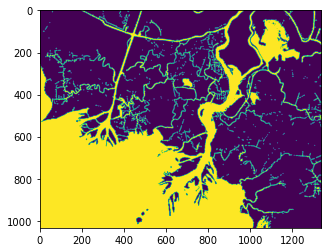

In [10]:
mask_original_crs = nd.morphology.binary_dilation(mask_original_crs, 
                                    iterations=1,
                                    border_value=0,
                                    structure=np.ones((3, 3)))

plt.imshow(mask_original_crs)

In [11]:
src_profile['count'] = 1
with rasterio.open(products_for_map_dir/'water_mask_original.tif', 'w', **src_profile) as ds:
    ds.write(mask_original_crs.astype(np.uint8), 1)

# Convert Mask into UTM

We want our resoulution cells (particularly for width computations) to be in UTM. Initially, we considered lat-lon CRS and used the Haversine distance. However, to avoid computing geometric lines with shapely (quite expensive) we use a grid in which distance is uniform across grid cells (UTM).

To do so, we will:

1. Find the appropriate UTM zone using the bounding box of our current array
2. Reproject our array into this utm zone with a reasonable resolution

For 1, we have to first translate our bounds to (lon, lat) so that we can determine our utm zone.

In [12]:
bounds_4326 = transform_bounds(src_crs, {'init':'epsg:4326'}, *bounds)
bounds_4326

(-91.54439999999998, 29.374499999999962, -91.08609999999999, 29.68319999999998)

In [13]:
midpoint = (bounds_4326[0] + bounds_4326[2]) / 2, (bounds_4326[1] + bounds_4326[3]) / 2
midpoint

(-91.31524999999999, 29.52884999999997)

In [14]:
epsg_utm = CRS({'init':convert_4326_to_utm(*midpoint)})
epsg_utm

CRS.from_epsg(32615)

Now, we reproject to this UTM zone.

In [15]:
epsg_utm

CRS.from_epsg(32615)

In [16]:
if map_name == 'stamen_terrain_12':
    target_resolution = 25
elif map_name == 'google_16':
    target_resolution=2
else:
    raise ValueError('only works for google_16 and stamen_terrain_12')

profile_utm = reproject_profile_to_new_crs(src_profile, 
                                           epsg_utm,
                                           # 2 meter resolution; closely matches tif in QGIS
                                           target_resolution=target_resolution
                                           )

In [17]:
src_profile['count'] = 1
profile_utm['count'] = 1
mask, _ = reproject_arr_to_match_profile(mask_original_crs.astype(np.uint8), 
                                         src_profile, 
                                         profile_utm,
                                         resampling='nearest', 
                                        )
mask = mask[0, ...].astype(bool)

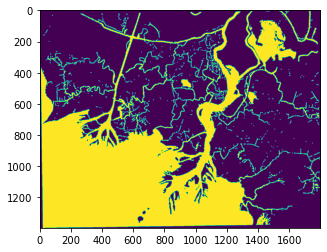

In [18]:
plt.imshow(mask)

In [19]:
src_profile['count'] = 4
profile_utm['count'] = 4
arr_utm, _ = reproject_arr_to_match_profile(src_arr, 
                                         src_profile, 
                                         profile_utm,
                                         resampling='nearest', 
                                        )
arr_utm = (arr_utm.transpose([1, 2, 0])[..., :3])
profile_utm

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1798, 'height': 1395, 'count': 4, 'crs': CRS.from_epsg(32615), 'transform': Affine(25.0, 0.0, 640825.0,
       0.0, -25.0, 3285225.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

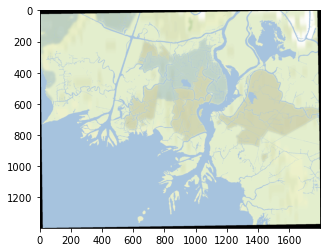

In [20]:
# Scale img so that plt.imshow can display - needs either (a) 0 to 1 as floats or (b) 0 to 255 as ints.
# We opt for (a)
plt.imshow(scale_img(arr_utm))

We used QGIS on the original mask to determine approximate color of water and some of the text labels.

In [21]:
profile_utm['count'] = 1
with rasterio.open(products_for_map_dir/'water_mask.tif', 'w', **profile_utm) as ds:
    ds.write(mask.astype(np.uint8), 1)

# Interface Mask / Ocean Mask

I drew these polygons pretty quickly in QGIS. They approxiamte where the channels run into the ocean with respect to the above tiff. This interface is slightly different for each image. 

One could use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943) to automate, but then there are may be problems at the channel mouth as these are created with some other dataset. Likely there would need to be some sort of post-processing (or hand editing) to make the prettier figures.

/Users/cmarshak/anaconda3/envs/test2/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


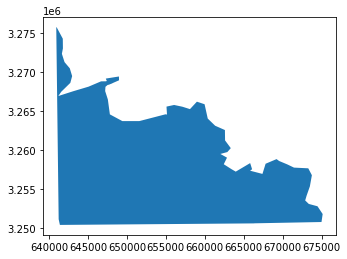

In [22]:
ocean_shapefile = data_path/f'{map_name}_interface'
ocean_df = gpd.read_file(ocean_shapefile).dropna().to_crs({'init': epsg_utm})
ocean_df.plot()

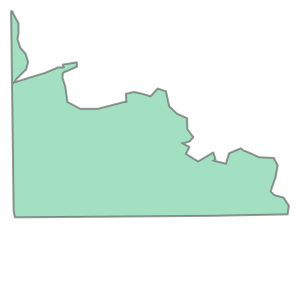

In [23]:
ocean_geometry = (ocean_df.geometry.buffer(1e-5).unary_union).buffer(30)
ocean_geometry

In [24]:
def translate_one(geometry, profile):
    """
    The geometry and profile need to have the same epsg codes otherwise this will fail (silently).
    """
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

In [25]:
ocean_mask = translate_one(ocean_geometry, profile_utm)

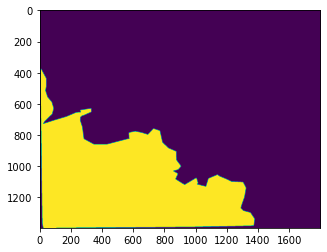

In [26]:
plt.imshow(ocean_mask)

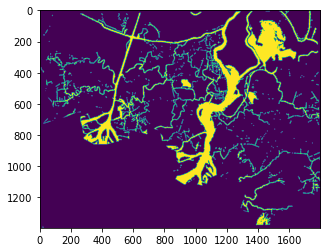

In [27]:
channel_mask = mask.astype(bool) & ~ocean_mask.astype(bool)
#channel_mask = filter_binary_array_by_min_size(channel_mask, .05 * np.sum(channel_mask))

plt.imshow(channel_mask)

In [28]:
with rasterio.open(products_for_map_dir/'ocean_mask.tif', 'w', **profile_utm) as ds:
    ds.write(ocean_mask.astype(np.uint8), 1)

In [29]:
with rasterio.open(products_for_map_dir/'channel_mask.tif', 'w', **profile_utm) as ds:
    ds.write(channel_mask.astype(np.uint8), 1)